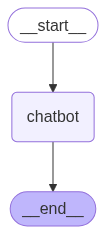

Assistant: Hello! How can I assist you today? 😊
Assistant: 你好！有什么我可以帮助你的吗？
Exiting...


In [ ]:
model_configs = {
    "base_url": "http://192.168.0.130:31665/v1/",
    "model_name": 'Qwen2.5-VL-32B-Instruct',
    "api_key": "289751f29159b7d25dadc86c858fa48405bba6740acb57154b00494c0308ed95"
}

In [ ]:
# 使用langGraph搭建聊天机器人
import sys
import os

# 设置环境变量，确保不走代理
os.environ['HTTP_PROXY'] = ''
os.environ['HTTPS_PROXY'] = ''
os.environ['http_proxy'] = ''
os.environ['https_proxy'] = ''
os.environ['NO_PROXY'] = '*'

# # Add the parent directory to the Python path so we can import config
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from openai import OpenAI

# 1.创建StateGraph对象，StateGraph对象定义聊天机器人的消息状态，相当于上下文
class State(TypedDict):
    """State of the chatbot"""

    messages: Annotated[list,add_messages]

graph_builder = StateGraph(State)

# 大模型api - 使用与test.py相同的方式
client = OpenAI(
    base_url=model_configs["base_url"],
    api_key=model_configs["api_key"],
)

def chatbot(state: State):
    """Chatbot function that uses OpenAI client for chat completions"""
    try:
        # Convert messages to the format expected by OpenAI
        messages = []
        for msg in state["messages"]:
            if isinstance(msg, dict):
                messages.append(msg)
            else:
                # Handle LangChain message objects
                messages.append({
                    "role": msg.type if hasattr(msg, 'type') else "user",
                    "content": msg.content if hasattr(msg, 'content') else str(msg)
                })
        
        # Create chat completion using the same approach as test.py
        response = client.chat.completions.create(
            messages=messages,
            model=model_configs["model_name"],
            temperature=1.0,
            timeout=60
        )
        
        # Extract the response content
        assistant_message = {
            "role": "assistant",
            "content": response.choices[0].message.content
        }
        
        return {'messages': [assistant_message]}
    except Exception as e:
        error_msg = str(e)
        if "502" in error_msg:
            error_content = "Sorry, the AI service is currently unavailable (502 error). Please try again later."
        elif "401" in error_msg:
            error_content = "Authentication error. Please check your API key."
        elif "404" in error_msg:
            error_content = "Model not found. Please check the model name."
        else:
            error_content = f"An error occurred: {error_msg}"
        
        print(f"Error in chatbot function: {error_msg}")
        return {'messages': [{"role": "assistant", "content": error_content}]}


# 2.添加node节点
graph_builder.add_node("chatbot",chatbot)

# 3.定义流程入口和连线
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 4.编译
graph = graph_builder.compile()

# 5.显示可视化图形（可选）
try:
    # 尝试在IPython环境中显示图形
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except ImportError:
    print("IPython not available, skipping graph visualization")
except Exception as e:
    print(f"Graph visualization failed: {e}")
    print("You can view the graph structure by printing the graph object:")
    print(graph)


# 6.执行流程
def stream_graph_updates(user_input: str):
    try:
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
            for value in event.values():
                # Handle the response properly - it's a dictionary, not an object
                if isinstance(value, dict) and "messages" in value:
                    messages = value["messages"]
                    if messages and isinstance(messages[-1], dict):
                        content = messages[-1].get("content", "No content")
                        print("Assistant:", content)
                    else:
                        print("Assistant: No response content")
                else:
                    print("Assistant: Unexpected response format")
    except Exception as e:
        print(f"Error in stream_graph_updates: {e}")
        print("Assistant: Sorry, I encountered an error processing your request.")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ['quit', 'exit','q']:
            print("Exiting...")
            break
        stream_graph_updates(user_input)
    except KeyboardInterrupt:
        user_input = 'What do you know about LangGraph?'
        print("Exiting..."+user_input)
        stream_graph_updates(user_input)
        break
